# ANALYSIS OF OUTPUT INDICATORS -  LCOG MODEL


## Preliminary steps: uploads required files and runs model

Imports required libraries and geometry files

In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import seaborn as sns
from shapely.geometry import Point
import matplotlib.pyplot as plt
import glob
import warnings; warnings.filterwarnings("ignore")
%matplotlib notebook
%matplotlib inline
import orca
zones = gpd.read_file('data/zones/zones.geojson')

/home/janowicz/anaconda2/envs/template/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/janowicz/anaconda2/envs/template/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Imports lcog modules that will be used

In [2]:
from lcog import datasources
from lcog import variables
from lcog import models
from lcog import simulate

range(400, 5000, 400)
Registering model step 'elcm5'
Registering model step 'tenure_choice_model'
Registering model step 'repm_sf_detached'
Registering model step 'repm_industrial'
Registering model step 'repm_duplex_townhome'
Registering model step 'elcm12'
Registering model step 'tenure_choice_model2'
Registering model step 'elcm6'
Registering model step 'tenure_choice_model1'
Registering model step 'elcm9'
Registering model step 'elcm1'
Registering model step 'elcm11'
Registering model step 'elcm2'
Registering model step 'repm_multifamily'
Registering model step 'elcm7'
Registering model step 'repm_retail'
Registering model step 'elcm10'
Registering model step 'elcm3'
Registering model step 'elcm8'
Registering model step 'elcm13'
Registering model step 'repm_residential'
Registering model step 'elcm15'
Registering model step 'elcm4'
Registering model step 'repm_office'
Registering model step 'hlcm2'
Registering model step 'household_relocation_choice_model'
Registering model step 'e

Runs simulation of LCOG model until 2013

In [ ]:
!python simulate.py -y 2013

Loads simulation output files and creates two dataframes: one for general indicators and one for indicators by building type. Each of these two dataframes contains data for all of the simulation years

In [3]:
filenames_zones_general=glob.glob('runs/**/zone_indicators_2*', recursive=True)
filenames_zones_buildingtype=glob.glob('runs/**/zone_indicators_building_type_*', recursive=True)
list_zones_general = [pd.read_csv(filename) for filename in filenames_zones_general]
list_zones_buildingtype = [pd.read_csv(filename) for filename in filenames_zones_buildingtype]
for dataframe, filename in zip(list_zones_general, filenames_zones_general):
    dataframe['filename'] = filename
for dataframe, filename in zip(list_zones_buildingtype, filenames_zones_buildingtype):
    dataframe['filename'] = filename

zones_general = pd.concat(list_zones_general, ignore_index=True)
zones_buildingtype = pd.concat(list_zones_buildingtype, ignore_index=True)
zones_general['year'] = zones_general.filename.apply(lambda x: int(x[-8:-4]))
zones_buildingtype['year'] = zones_buildingtype.filename.apply(lambda x: int(x[-8:-4]))


## Creates functions to create maps and charts from simulation results

This part of the notebook creates three types of functions to visualize and summarize output variables, as described below.

Function to generate a bar chart showing changes in a given variable throughout the years:

* timeline(df, variable_name)

    -df = dataframe containing the output indicator to visualize (i.e. zones_general)
    
    -variable_name = variable within indicator_df to visualize (i.e. 'total_households')


Function to map changes in a given output indicator by zone:

* visualize_variable(indicator_df, variable_name, geography_index, initial_year, final_year, change_type, sign)

    -indicator_df = dataframe containing the output indicator to visualize (i.e. zones_general)
    
    -variable_name = variable within indicator_df to visualize (i.e. 'total_households')
    
    -geography_index = index of the shapefile containing the geographical units to visualize (i.e. 'zone_id')
    
    -initial_year = initial year to calculate the change in the variable to visualize (i.e. 2011)
    
    -final_year = final year to calculate the change in the variable to visualize (i.e. 2020)
    
    -change_type = 'Absolute' or 'Percentage'. (The 'Percentage' option returns zero for those zones that had a zero
    in the analyzed variable at the initial year.  
    
    -sign =  'positive' or 'negative'. This is the sign of the change that the user wants to visualize




Function to generate a bar chart showing changes in a given output indicator by an aggregate geography:

* agg_geo(df, aggregate_geography, variable, initial_year, final_year)

    -df = dataframe containing the output indicator to summarize (i.e. zones_general)
    
    -aggregate_geography_index = index of geographical level used to summarize output indicator (i.e. 
    zone_district_id)
    
    -variable = variable to summarize (i.e. 'total_households)
    
    -initial_year = initial year to calculate the change in the variable to summarize (i.e. 2011)
    
    -final_year = initial year to calculate the change in the variable to summarize (i.e. 2011)




In [4]:

def timeline(df, variable):
    sns.barplot(x='year', y=variable, data=df)
    plt.show()
    
def visualize_variable(indicator_df, variable_name,geography_index, initial_year, final_year, change_type, sign):
    indicator_df = indicator_df[[geography_index, variable_name, 'year']].copy()  
    indicator_df_initial = indicator_df[indicator_df['year']== initial_year].copy()
    indicator_df_final = indicator_df[indicator_df['year']== final_year].copy()
    indicator_df_final.rename(columns={variable_name: 'variable_final'}, inplace=True)
    indicator_df = pd.merge(indicator_df_initial, indicator_df_final, on=geography_index, how='left')
    indicator_df['delta']=indicator_df['variable_final']-indicator_df[variable_name]     
    indicator_df['delta']=indicator_df['delta'].fillna(0)
    geography_df = pd.merge(zones, indicator_df, on=geography_index, how='left')
    geography_df['delta']=geography_df['delta'].fillna(0)    
    if change_type=='Percentage':
        geography_df.loc[geography_df[variable_name]==0,'delta']=0
        geography_df.loc[geography_df[variable_name]>0,'delta']=geography_df['delta']/geography_df[variable_name]*100
    if sign == 'increase':
        geography_df.loc[geography_df['delta']<0, 'delta'] = 0
    elif sign == 'decrease':
        geography_df.loc[geography_df['delta']>0, 'delta'] = 0 
    if geography_df[geography_df['delta']!=0].empty:
        print ('------------------------------------------------------------------------------------------')
        print ('No '+ sign +' in ' + variable_name + ' between ' + str(initial_year) + ' and ' + str(final_year))
        print ('------------------------------------------------------------------------------------------')
    elif geography_df[geography_df['delta']!=0].empty == False:
        title=change_type+' '+sign+' in '+variable_name.replace('_', ' ')+' per Zone from '+str(initial_year)+" to "+str(final_year)
        base=geography_df.plot(column='delta',cmap='viridis',alpha=.8,vmin=-1,scheme='equal_interval', figsize=(10, 10),legend=True)
        plt.suptitle(title, fontsize=20)
        base.set_axis_off()
        plt.axis('equal')
        plt.show()
    
    return geography_df

def agg_geo(df, aggregate_geography_index, variable, initial_year, final_year):
    parcels=orca.get_table('parcels').to_frame(["parcel_id",'zone_id',aggregate_geography_index])
    df = pd.merge(df,parcels, on='zone_id', how='left')
    df = df[(df['year']==initial_year) | (df['year']==final_year)]
    sns.factorplot(x=aggregate_geography_index, y=variable, hue='year', data=df, kind='bar',size=6, aspect=2.5)
    plt.show()


# Generates a bar chart comparing each variable over the years

First, it's important to see how the variables change in aggregate throughout the years. To do this, the timeline( ) function created above is applied to some selected variables to generate bar charts that show the total change. 

The charts below show how jobs and households increase more sharply during the first simulation years and then continue growing but at lower rates. Residential units and non residential sqft grow drastically at specific years when they need to achieve a target vacancies, and remain constant after these jumps while the vacancy is above the target. 

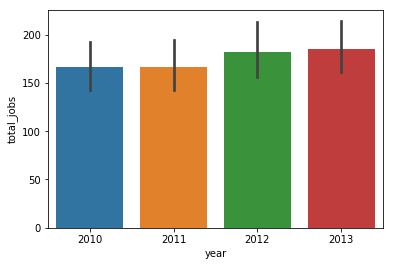

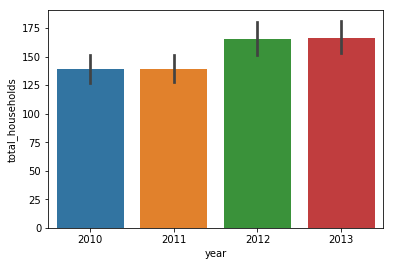

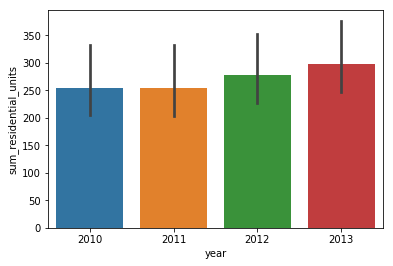

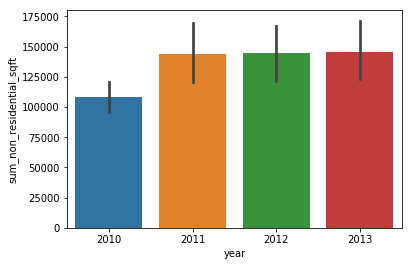

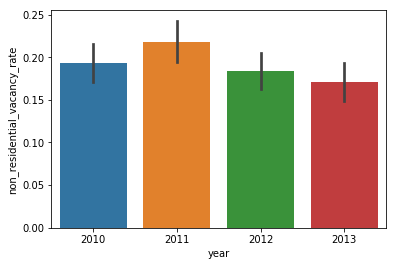

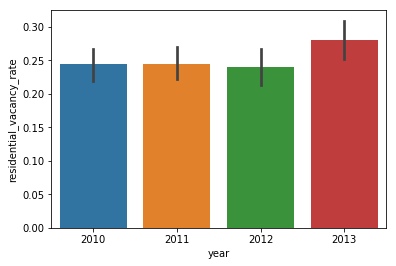

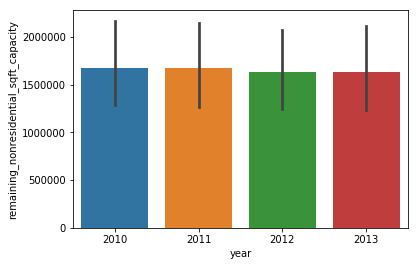

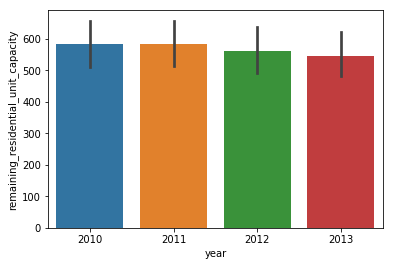

In [5]:
variables = ['total_jobs', 'total_households', 'sum_residential_units', 'sum_non_residential_sqft','non_residential_vacancy_rate', 'residential_vacancy_rate', 'remaining_nonresidential_sqft_capacity', 'remaining_residential_unit_capacity']
for variable in variables:
    df = timeline(zones_general, variable)

## Plots the absolute change in each variable during the simulation period


After looking at the variables in aggregate, it's interesting to look at their spatial distribution. 

This part of the notebook applies the visualize_variable function created above to plot maps of absolute change in multiple selected variables between the start and the final year of the simulation. 

The changes are shown by zone, with plots of increase in each variable shown first and plots of decrease in each variable shown later on.

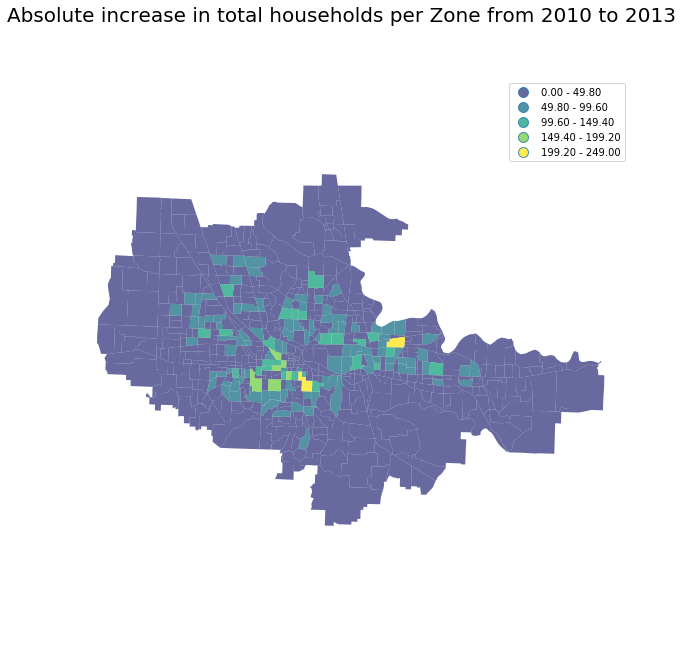

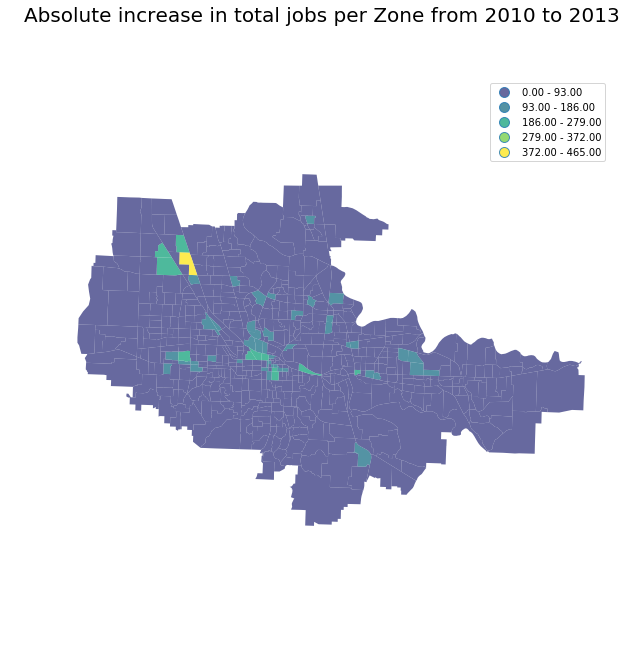

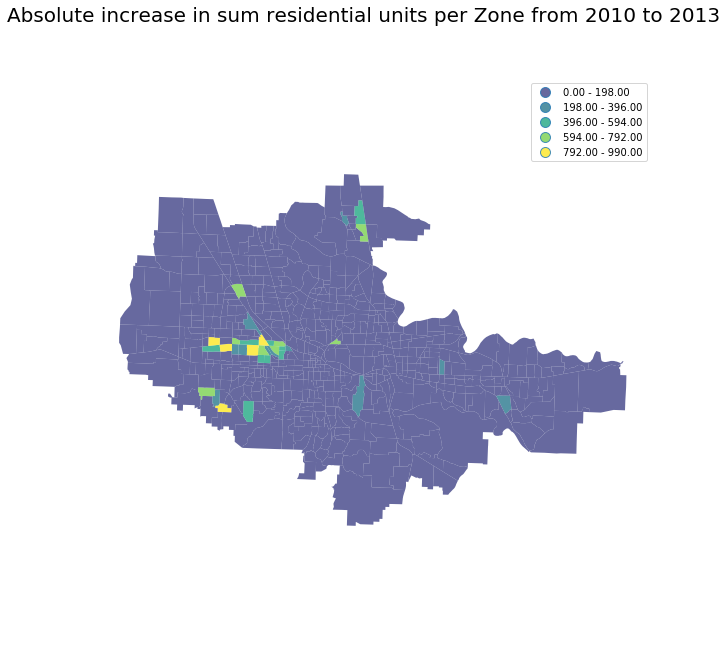

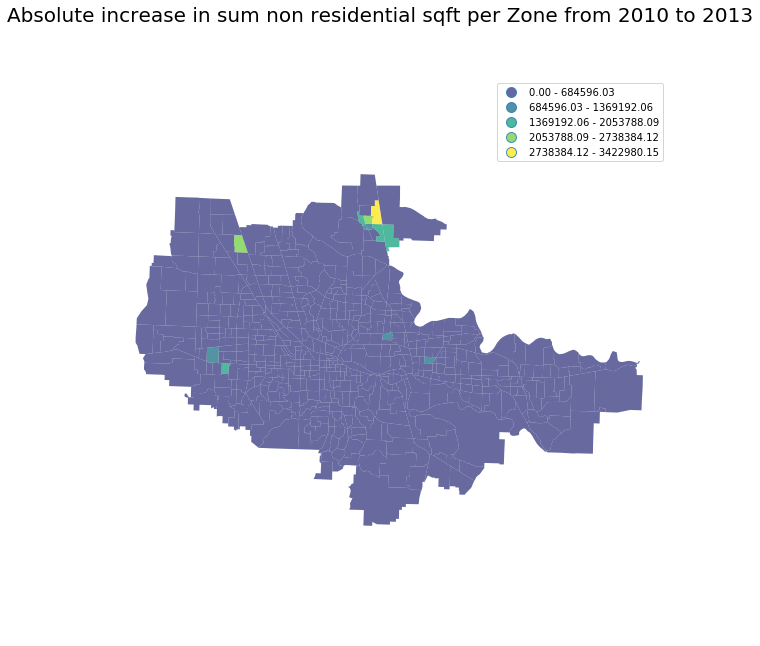

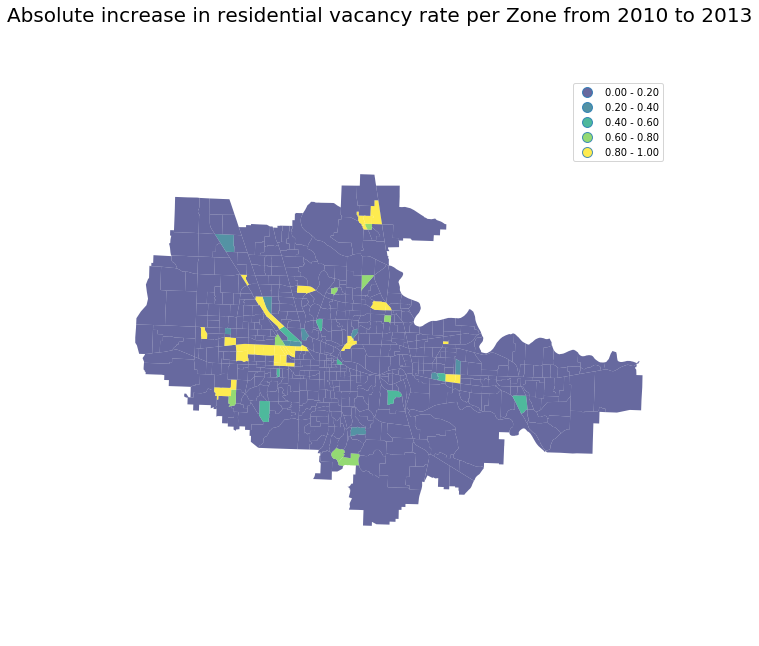

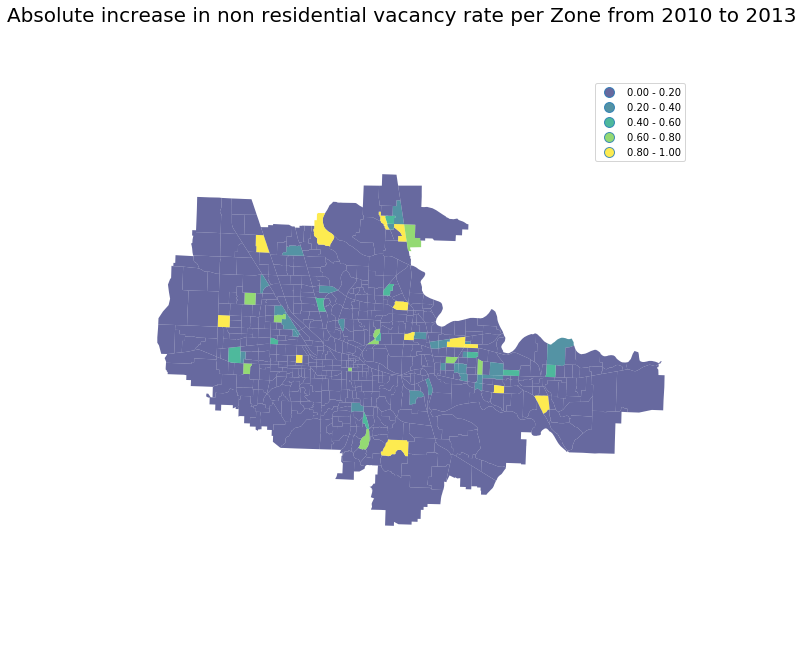

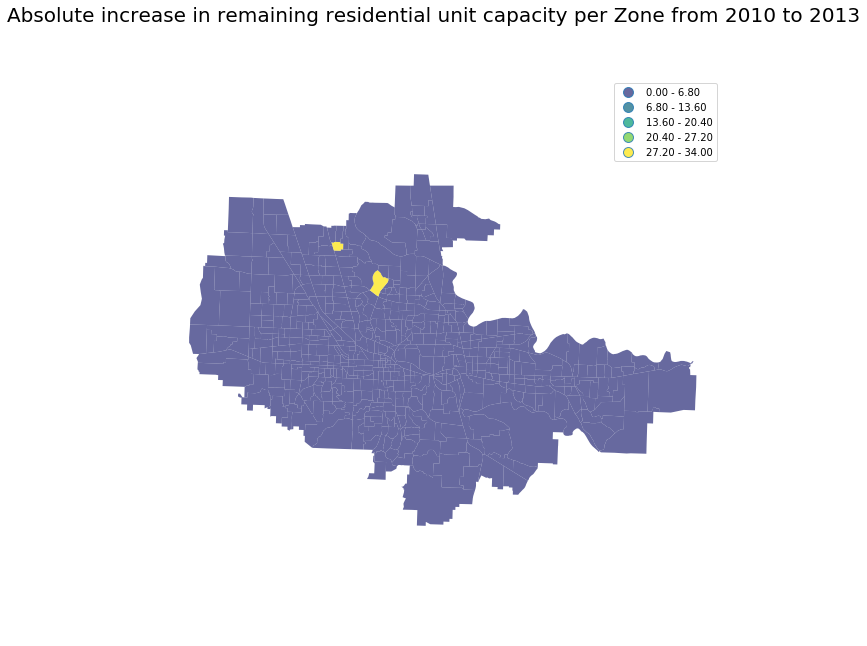

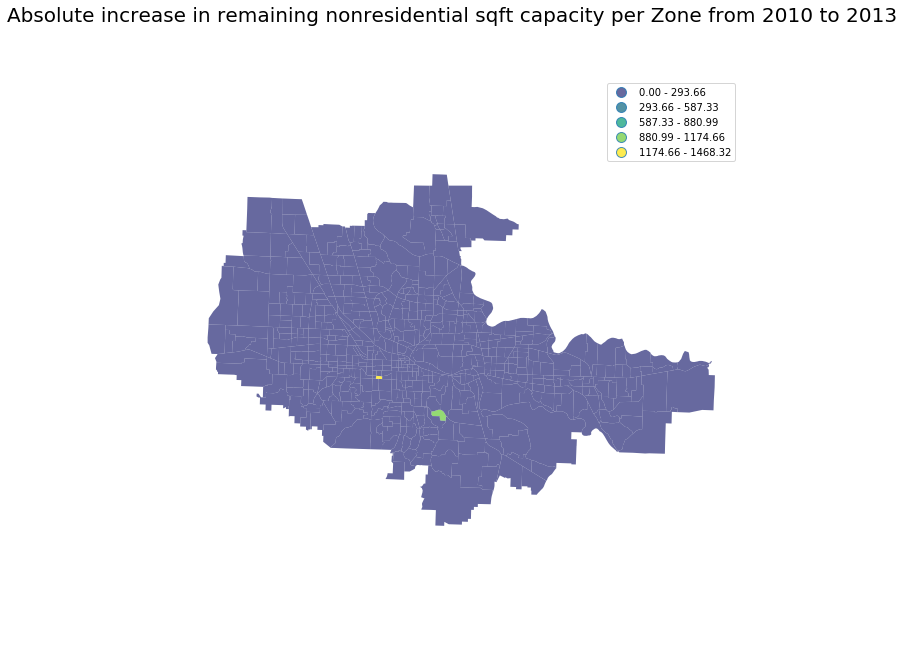

In [6]:
variables = ['total_households', 'total_jobs', 'sum_residential_units','sum_non_residential_sqft', 'residential_vacancy_rate','non_residential_vacancy_rate', 'remaining_residential_unit_capacity', 'remaining_nonresidential_sqft_capacity']
for variable in variables:
    visualize_variable(zones_general,variable,'zone_id', 2010, 2013, 'Absolute', 'increase')



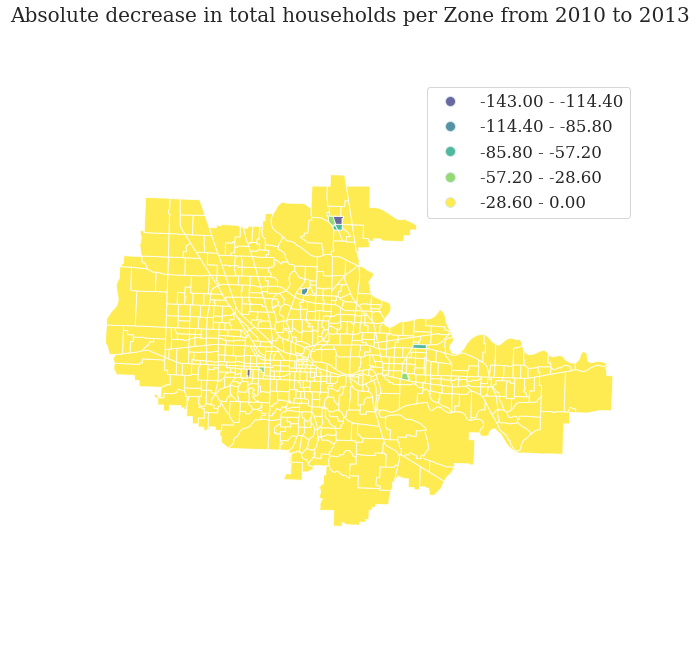

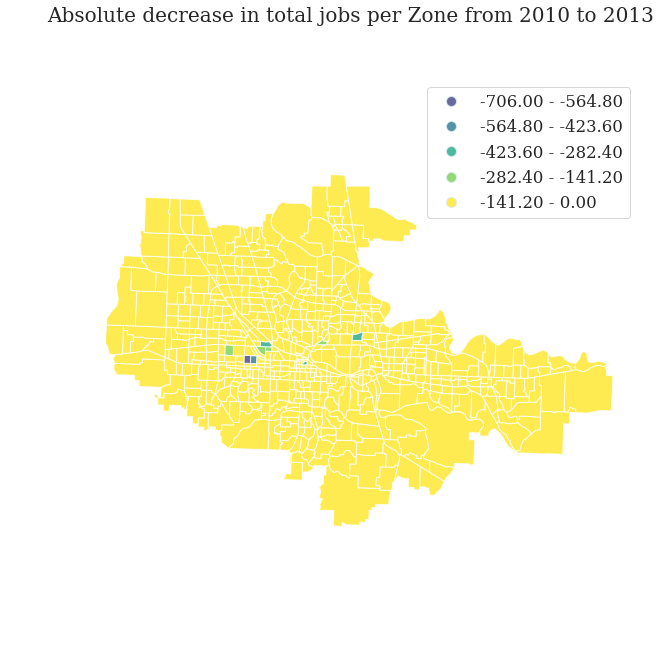

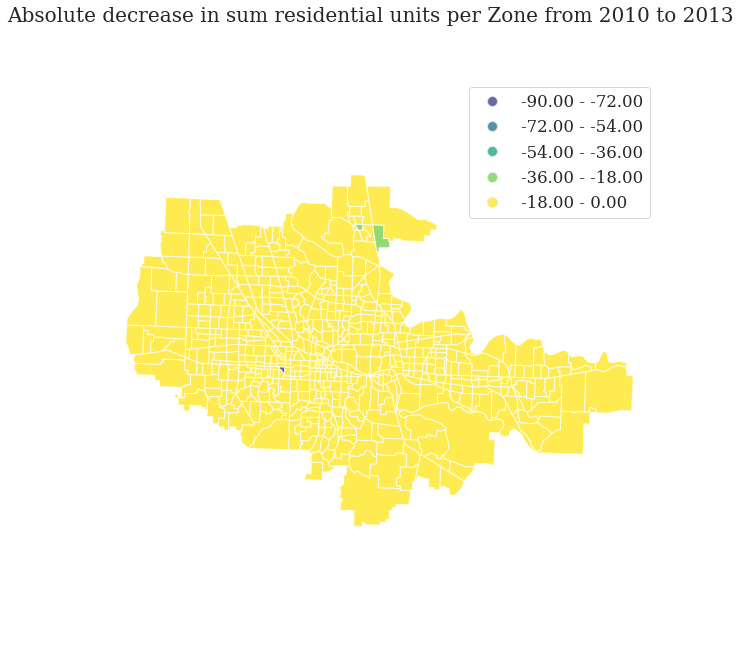

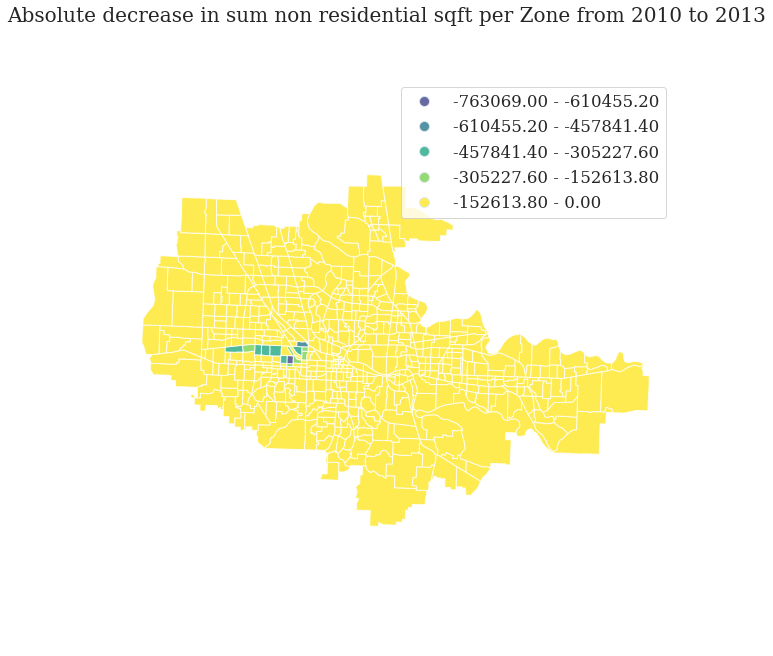

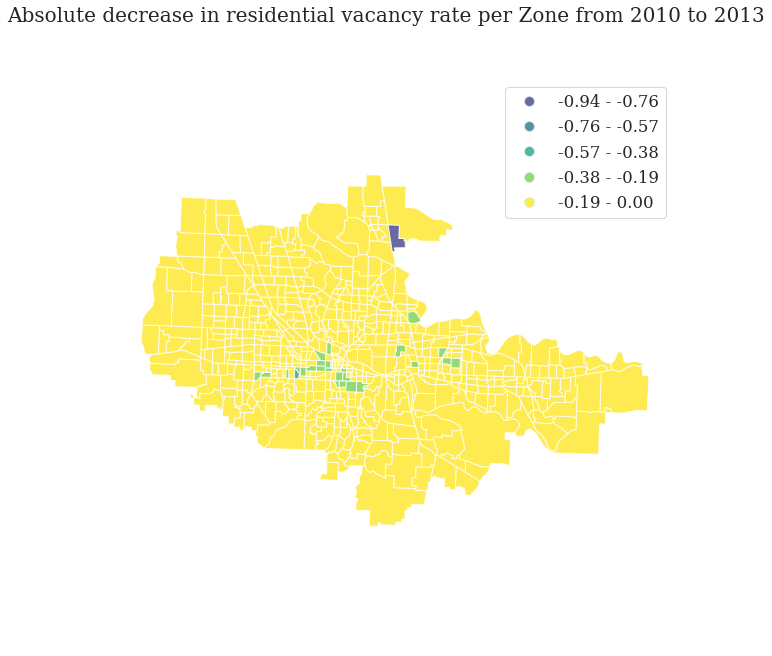

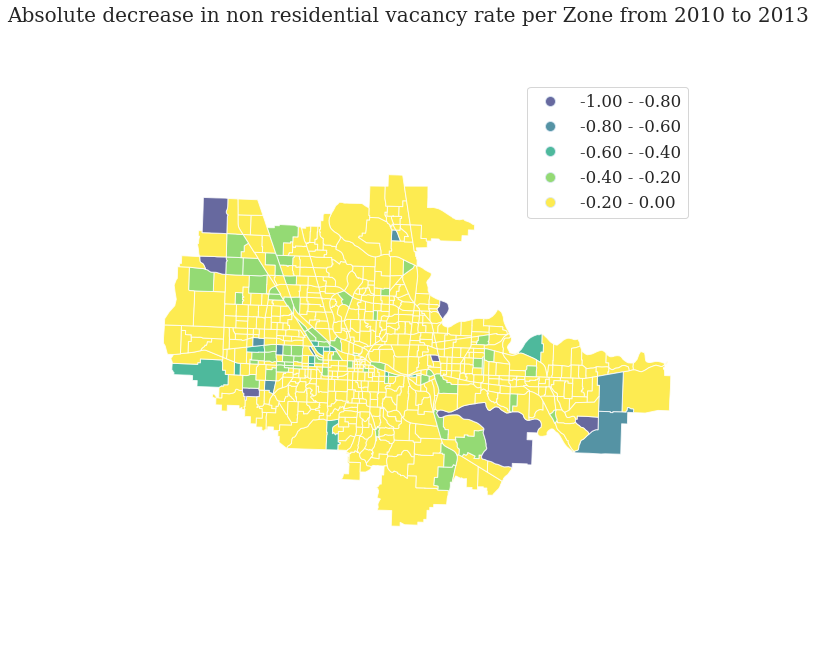

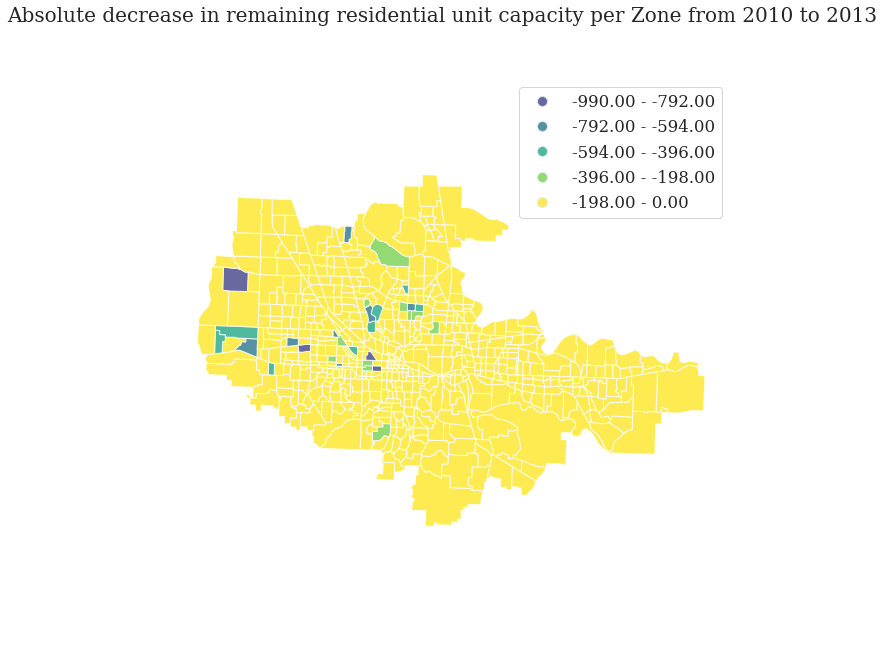

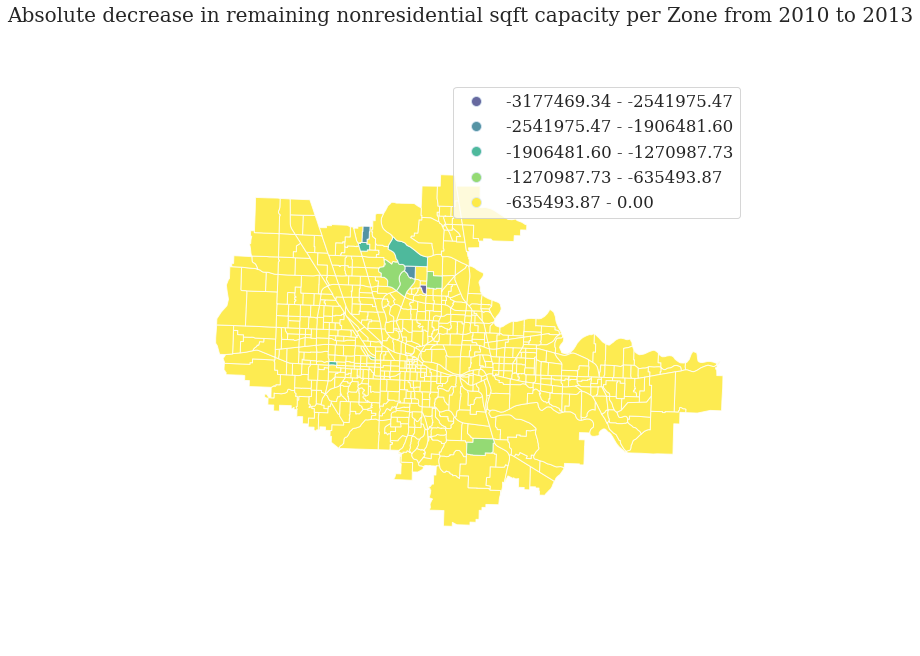

In [14]:
variables = ['total_households', 'total_jobs', 'sum_residential_units','sum_non_residential_sqft', 'residential_vacancy_rate','non_residential_vacancy_rate', 'remaining_residential_unit_capacity', 'remaining_nonresidential_sqft_capacity']
for variable in variables:
    visualize_variable(zones_general,variable,'zone_id', 2010, 2013, 'Absolute', 'decrease')


## Plots the percentage change in each variable during the simulation period

While the maps above showed absolute changes, it's also interesting to see which zones had the largest percentual changes. 

This part of the notebook applies the visualize_variable function to plot maps of percentage change in multiple selected variables between the start and the final year of the simulation. 

The changes are shown by zone, with plots of percentage increase in each variable shown first and plots of percentage decrease in each variable shown later on.

Zones that had zero values at the initial year are shown with zero percentual change even if they have a different value at the end of the simulation


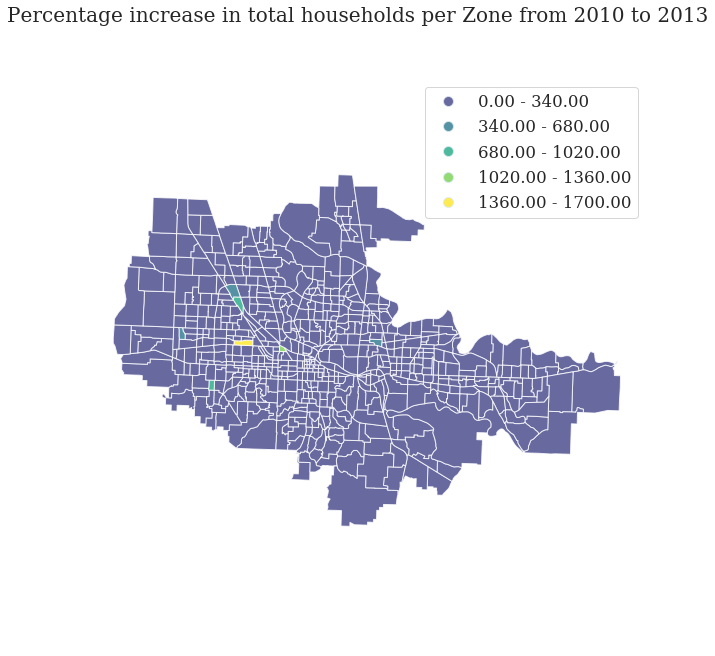

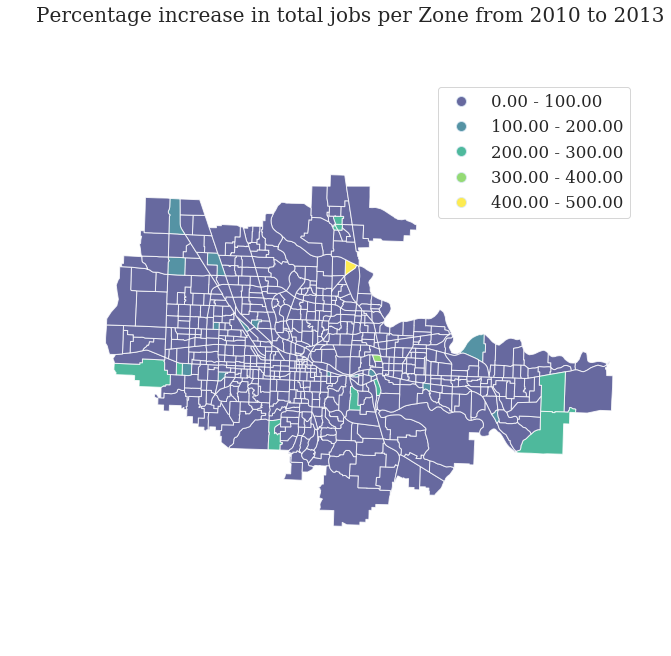

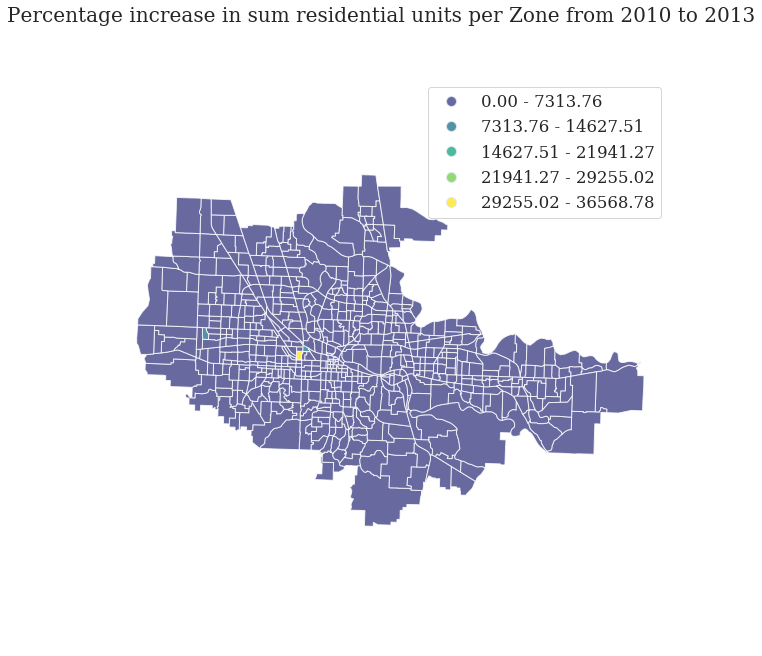

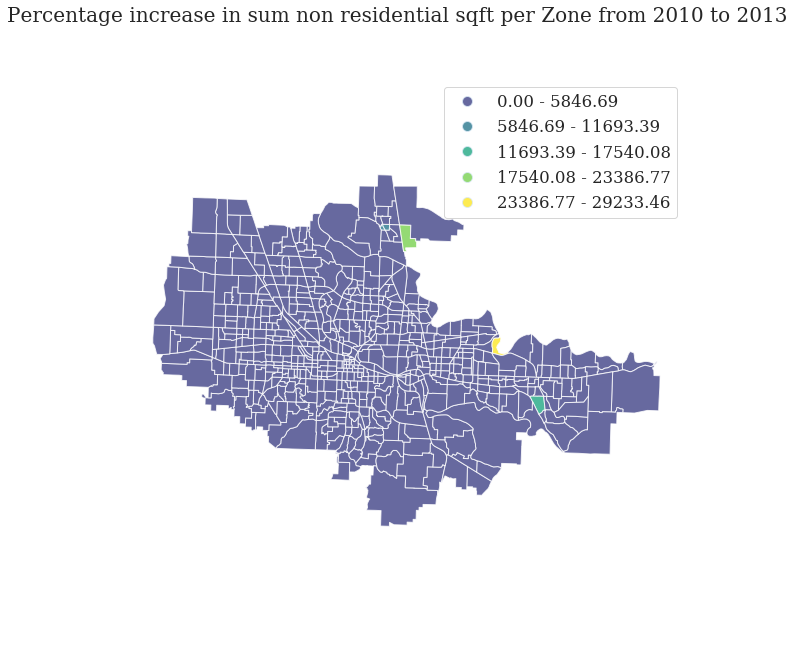

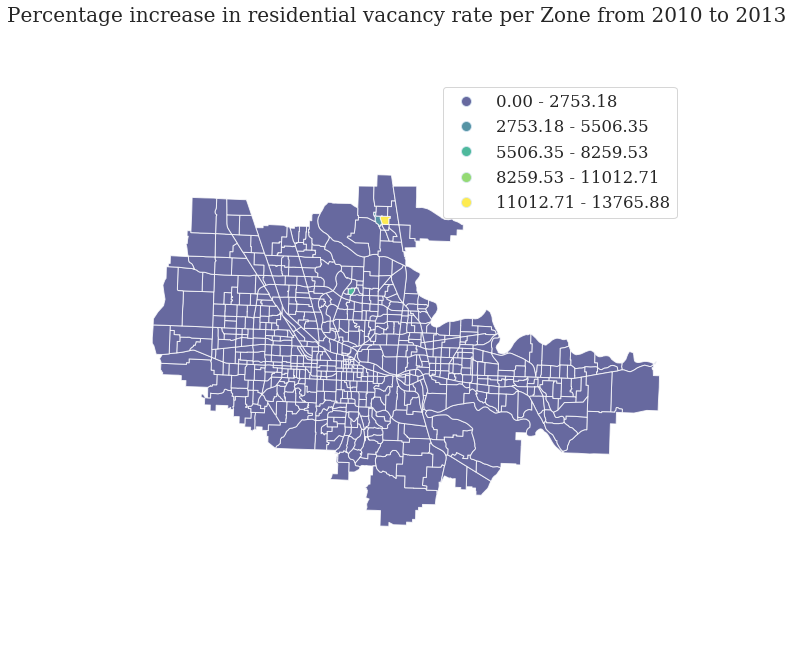

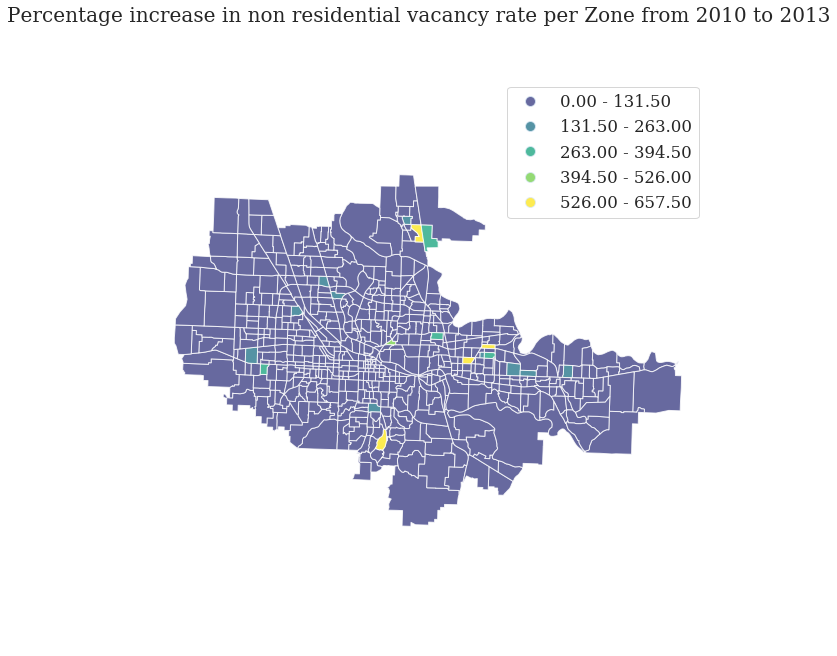

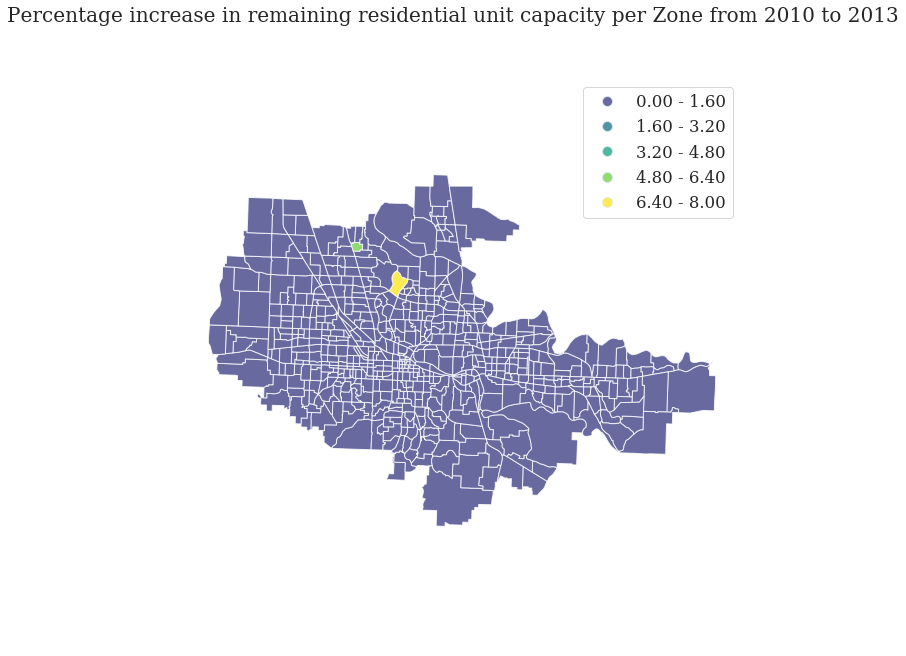

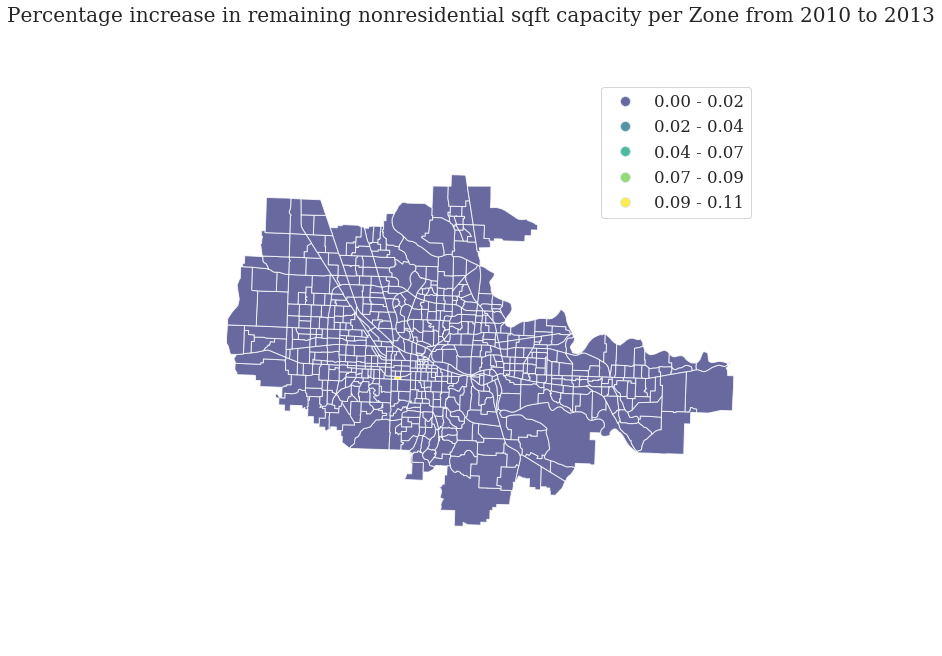

In [13]:
variables = ['total_households', 'total_jobs', 'sum_residential_units','sum_non_residential_sqft', 'residential_vacancy_rate','non_residential_vacancy_rate', 'remaining_residential_unit_capacity', 'remaining_nonresidential_sqft_capacity']
for variable in variables:
    visualize_variable(zones_general,variable,'zone_id', 2010, 2013, 'Percentage', 'increase')


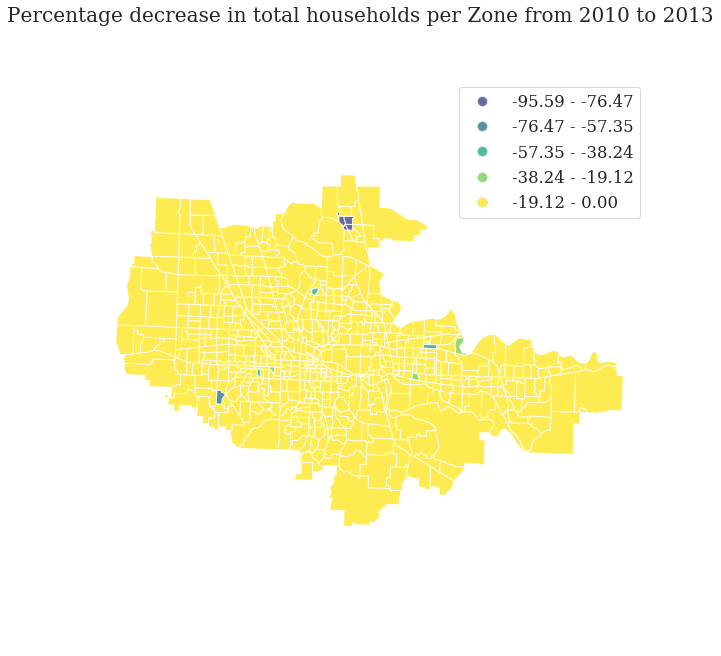

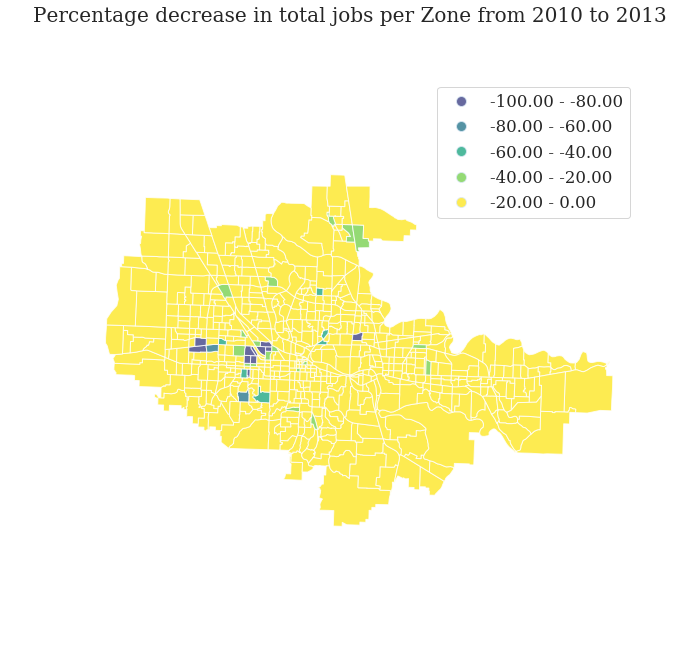

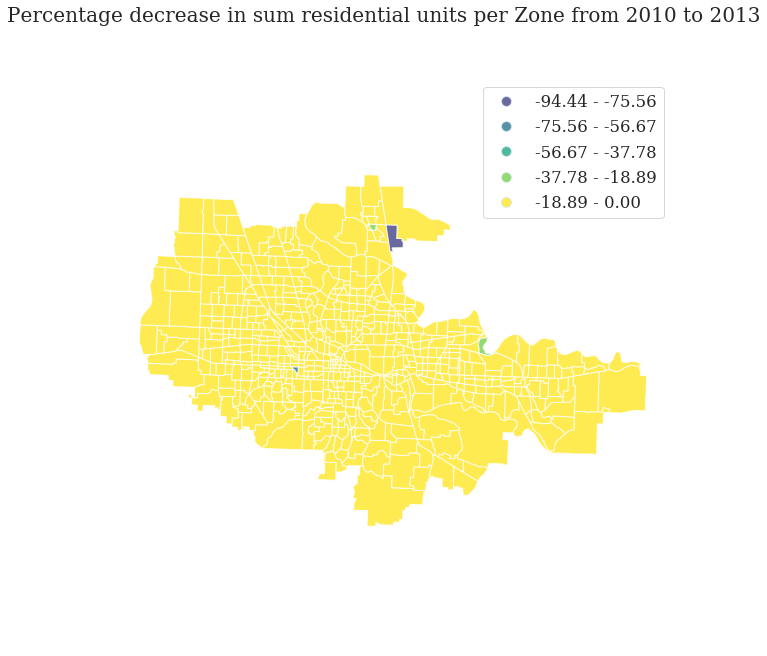

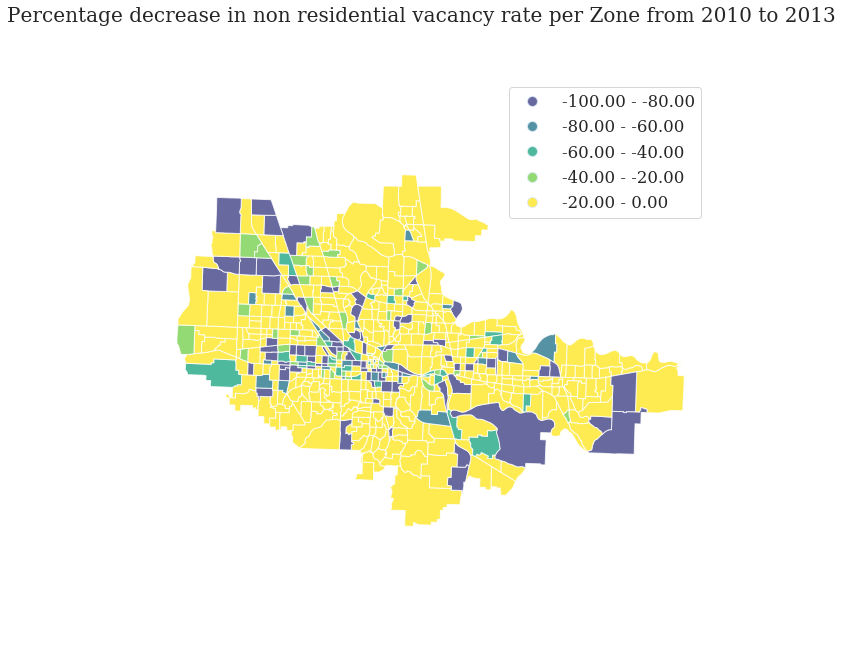

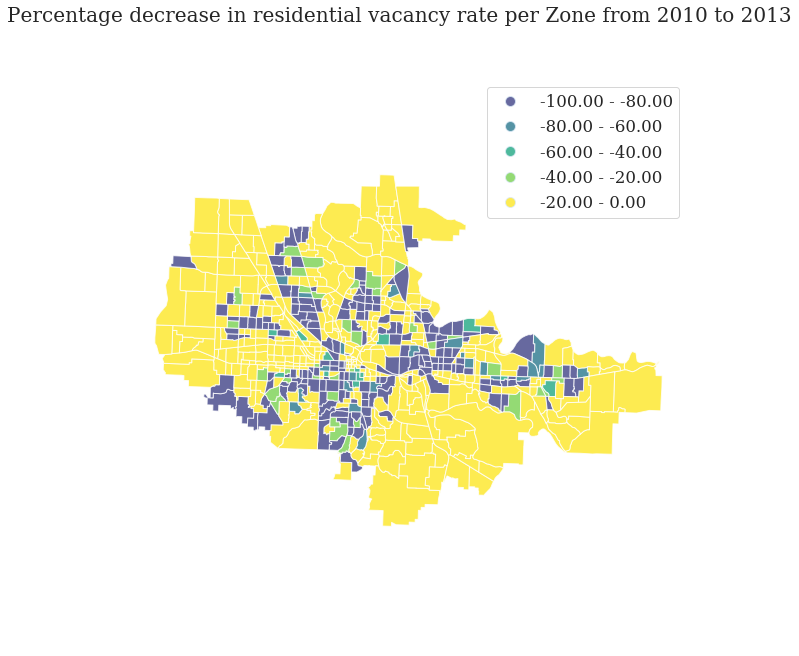

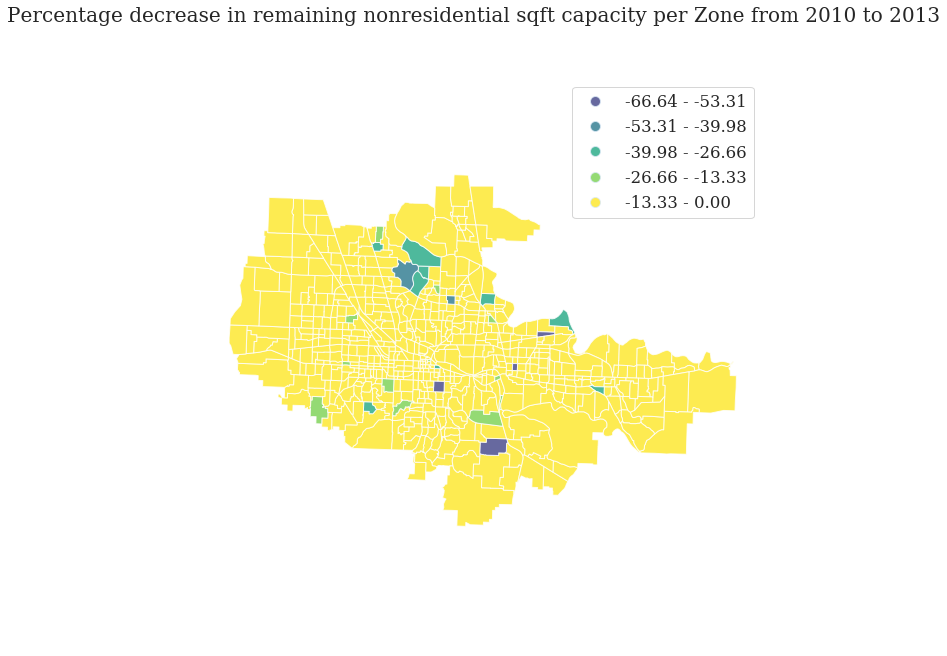

In [12]:
variables = ['total_households', 'total_jobs', 'sum_residential_units', 'non_residential_vacancy_rate', 'residential_vacancy_rate', 'remaining_nonresidential_sqft_capacity']#, 'remaining_residential_unit_capacity']#, 'sum_non_residential_sqft', '
for variable in variables:
    visualize_variable(zones_general,variable,'zone_id', 2010, 2013, 'Percentage', 'decrease')


## Generates a bar chart comparing the original and final value that each variable took during the simulation period

Finally, this section shows the changes in output variables by zone_district_id. 

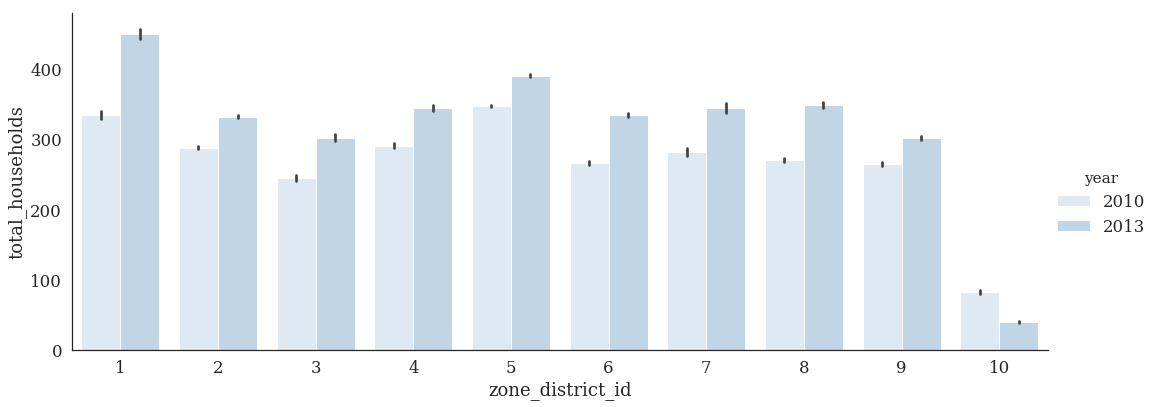

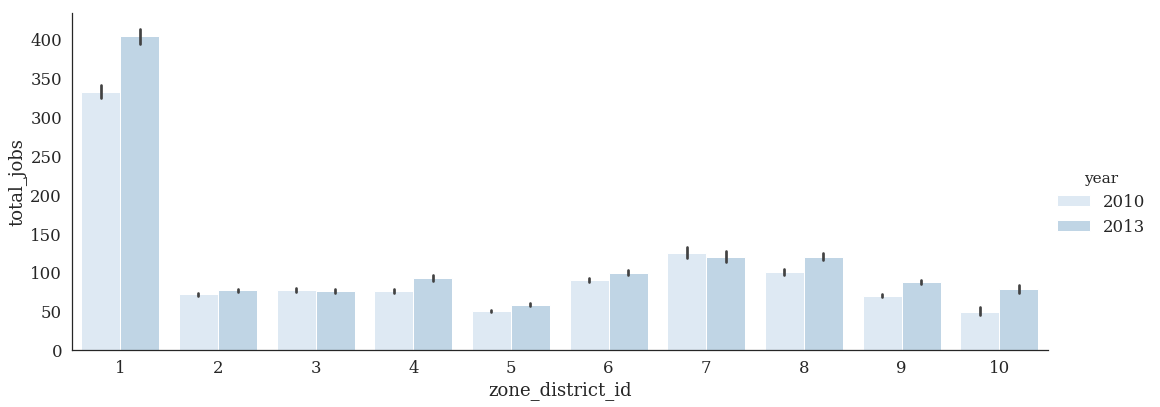

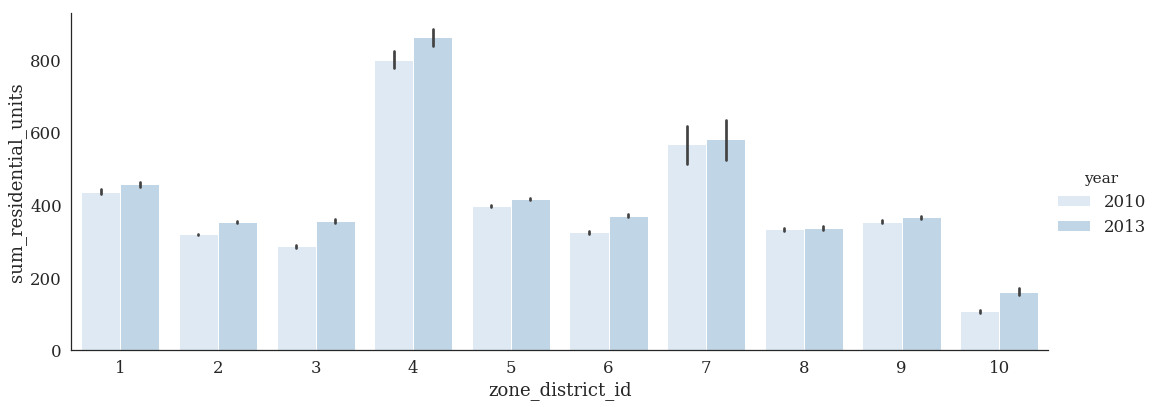

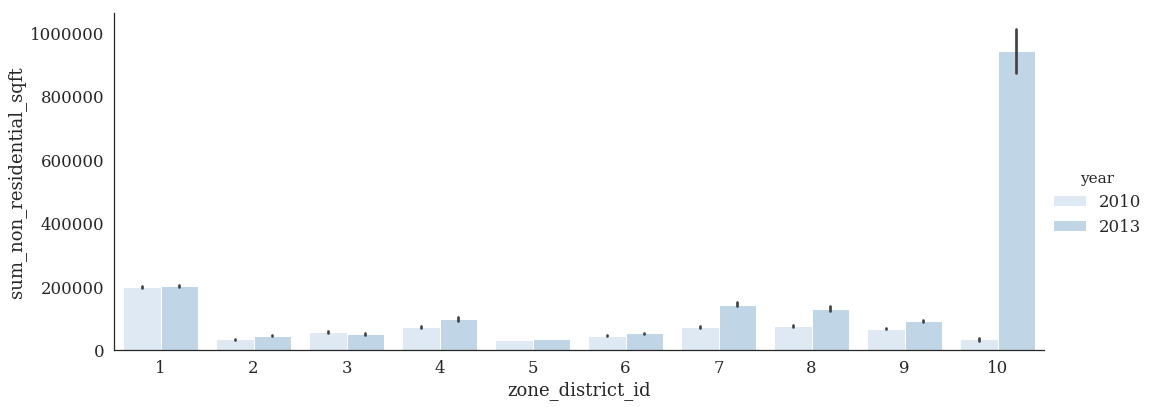

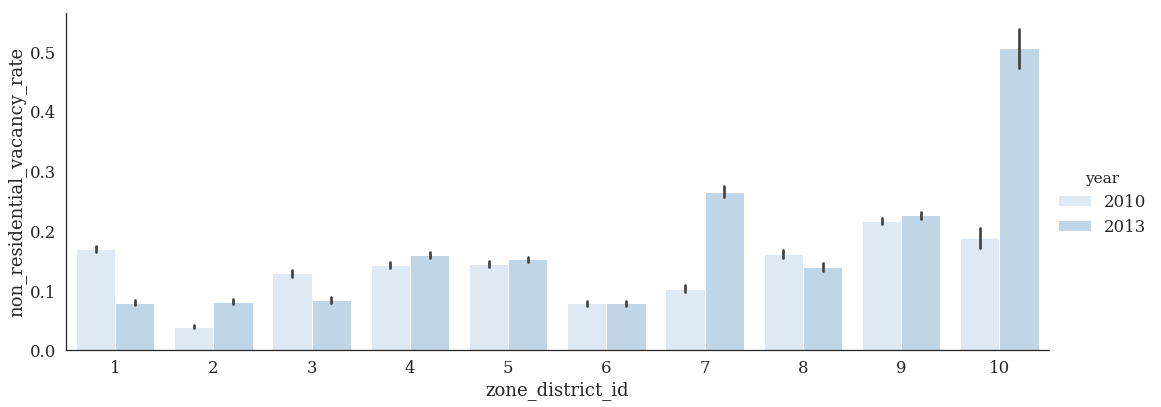

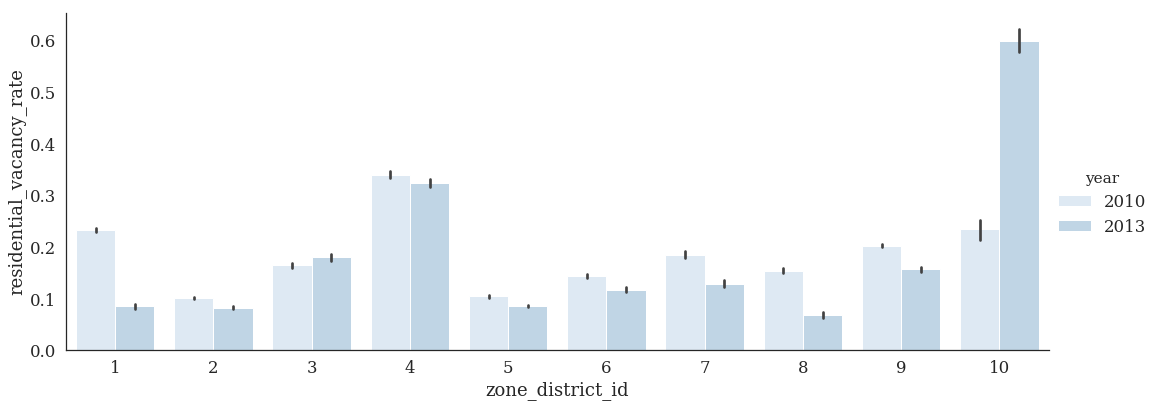

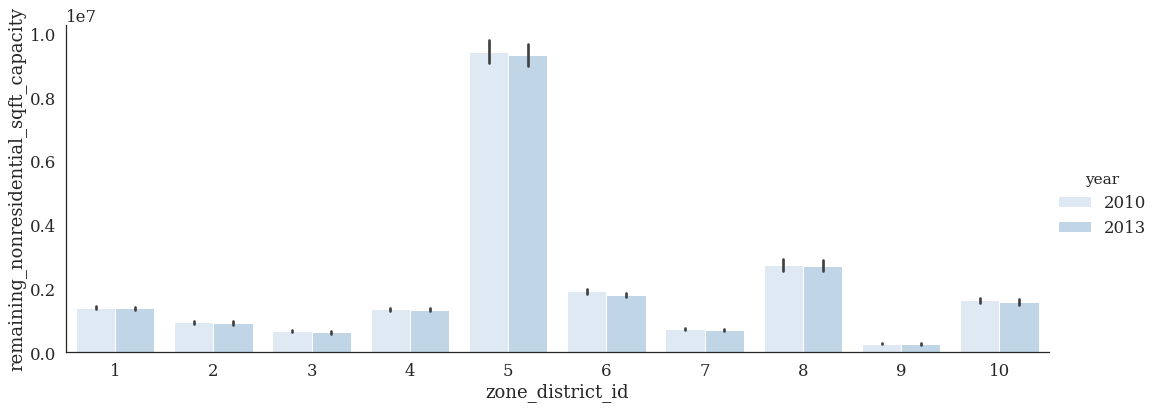

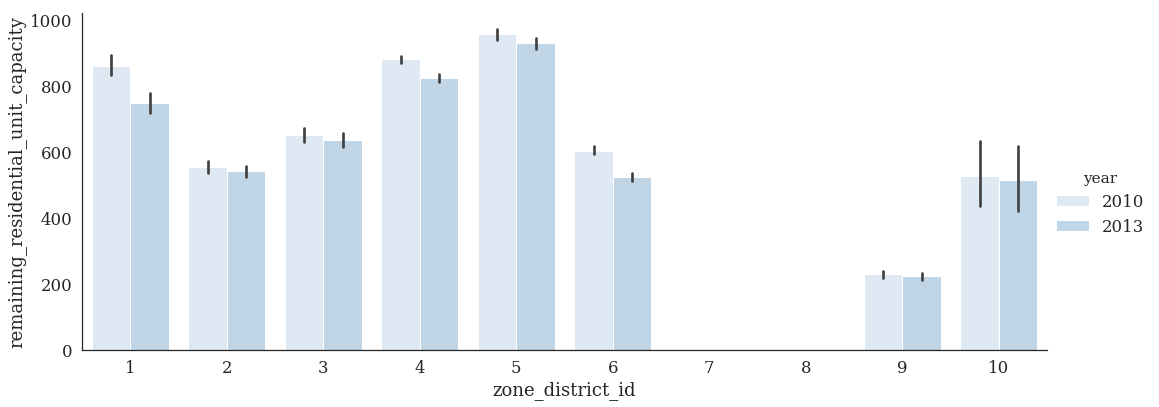

In [11]:
variables = ['total_households', 'total_jobs', 'sum_residential_units', 'sum_non_residential_sqft', 'non_residential_vacancy_rate', 'residential_vacancy_rate', 'remaining_nonresidential_sqft_capacity', 'remaining_residential_unit_capacity']

sns.set_context("paper", rc={"font.size":15,"axes.titlesize":12,"axes.labelsize":12,"hue.labelsize":12})   
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_style("white", {"font.family": "serif","font.serif": ["Times", "Palatino", "serif"]})
sns.set_palette('Blues')

for variable in variables: 
    agg_geo(zones_general, 'zone_district_id', variable, 2010, 2013)
    
